# Introduction

LOBPCG is a method for finding the smallest (or largest) eigenvalues
and the corresponding eigenvectors of a symmetric positive defined
generalized eigenvalue problem
([A Knyazev, 2001](https://epubs.siam.org/doi/abs/10.1137/S1064827500366124)).
Several implementations of the method exists. In this notebook we compare the
implementations of SciPy (see [scipy.sparse.linalg.lobpcg](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lobpcg.html))
and PyTorch (see [PR 29488](https://github.com/pytorch/pytorch/pull/29488)).

## User-interfaces

SciPy and PyTorch user-interfaces are similar:
```
import scipy.sparse.linalg
scipy.sparse.linalg.lobpcg(A, X, B=None, M=None, Y=None, tol=None, maxiter=None, largest=True, verbosityLevel=0, retLambdaHistory=False, retResidualNormsHistory=False) -> E, V [, lambdas, rnorms]

import torch
torch.lobpcg(A, B=None, k=1, X=None, n=None, iK=None, niter=1000, tol=None, largest=True, tracker=None, method=None, **params) -> E, V
```
but with the following notable differences:
1. The initial estimate `X` is mandatory for scipy lobpcg but optional for torch lobpcg. In the later case, the initial estimate will be random (using normal distribution N(0, 1)) tensor of size `(A.shape[::-1], n)`.
2. The preconditioner argument: scipy uses `M` (as approximation to inverse of `A`), torch uses `iK` (as inverse of a general preconditioner matrix `K`).
3. The number of requested eigenpairs: scipy deducts this from the shape of `X` while torch uses the argument `k`.
4. The block size: in scipy it is the same as the number of requested eigenpairs while torch uses the argument `n` which can be specified larger than `k` to ensure better convergence properties.
5. The number of iterations argument: in scipy, the number is specified by `maxiter` (as the maximum number of iterations, default is 20) while in torch by `niter` (as the number of iterations, default is 1000, can be negative with the meaning of iterate until convergence criteria is satisfied).
6. Convergence criteria, the argument `tol`: scipy uses `||A V - diag(E) B V|| < tol` where `tol=A.shape[-1] sqrt(feps)`, torch uses `||A V-diag(E) B V|| < tol * ||X|| (||A|| + ||E|| ||B||)` where `tol=sqrt(feps)` and estimates `||A|| = ||A X||/||X||`, `||B||=||B X||/||X||` are used. `feps` is minimal positive floating point number.
7. Tracking the convergence: scipy allows tracking only the eigenvalues and residuals (see `retLambdaHistory` and `retResidualNormsHistory` arguments) while torch allows tracking all variables involved in the iteration process (see `tracker` callable argument).
8. Supported methods: scipy implements LOBPCG with soft-locking of converged eigen-pairts, torch implements the original method (`method="basic"`) and the soft-locking method with orthogonalization procedure (`method="ortho"`, the default, most robust).
9. torch does not implement constraints support (the `Y` argument).

## A test with default arguments

In [3]:
m = 5000  # size of the square matrix
k = 7     # the number of requested eigenpairs
A1 = random_sparse_pd_matrix(m, density=2.0/m)
B1 = random_sparse_pd_matrix(m, density=2.0/m)
X1 = torch.randn((m, k), dtype=torch.double)
A2 = toscipy(A1)
B2 = toscipy(B1)
X2 = toscipy(X1)

In [4]:
E1, V1 = torch.lobpcg(A1, X=X1, k=k)
print(f"E1={E1.numpy()}")
E2, V2 = scipy_lobpcg(A2, X2)
print(f"E2={E2}")
E2t, V2t = torch.lobpcg(A2, X=X2, k=k)
print(f"E2t={E2t}")

E1=[1.     0.9998 0.9996 0.9994 0.9992 0.999  0.9988]
E2=[0.99838111 0.99759313 0.99699264 0.99672419 0.99625764 0.99550297
 0.99429996]
E2t=[1.     0.9998 0.9996 0.9994 0.9992 0.999  0.9988]


The less accurate result of `scipy_lobpcg` is caused by the too small default value `20` to `maxiter` argument. So, in the following we always specify the same number of iterations for both lobpcg implementations.

## Tracking of convergence

As the exact eigenvalues are known and the two lobpcg implementations use different convergence criteria, we only present the convergence of eigenvalues:

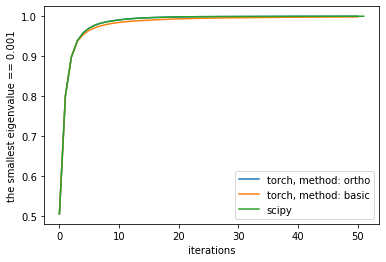

In [6]:
eigenvals = np.arange(1, m)/m

# torch.lobpcg, default method="ortho"
eigenvals1 = []
def tracker(E, **params):
    eigenvals1.append(E.tolist())
E1, V1 = torch.lobpcg(A1, X=X1, niter=niter, tracker=tracker)
eigenvals1 = np.array(eigenvals1)

# torch.lobpcg, method="basic"
eigenvals1b = []
def tracker(E, **params):
    eigenvals1b.append(E.tolist())
E1b, V1b = torch.lobpcg(A1, X=X1, niter=niter, tracker=tracker, method="basic")
eigenvals1b = np.array(eigenvals1b)

# scipy.sparse.linalg.lobpcg
E2, V2, eigenvals2 = scipy_lobpcg(A2, X2, maxiter=niter, retLambdaHistory=True)
eigenvals2 = np.array(eigenvals2)

plt.plot(eigenvals1[:,0], label='torch, method: ortho')
plt.plot(eigenvals1b[:,0], label='torch, method: basic')
plt.plot(eigenvals2[:,0], label='scipy')
plt.legend(); plt.xlabel('iterations'); plt.ylabel('the smallest eigenvalue == 0.001');

As seen, the convergence of scipy and torch lobpcg iteration processes are practically identical, except for the `method="basic"` when the convergence is slightly slower.

## Timings

In [8]:
%timeit torch.lobpcg(A1, X=X1, B=None, niter=niter, method="ortho")
%timeit torch.lobpcg(A1, X=X1, B=None, niter=niter, method="basic")
%timeit torch.lobpcg(A2, X=X2, B=None, niter=niter, method="ortho")
%timeit torch.lobpcg(A2, X=X2, B=None, niter=niter, method="basic")
%timeit scipy_lobpcg(A2, X2, B=None, maxiter=niter)

320 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
190 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
264 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
228 ms ± 54.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
139 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As seen, scipy is fastest and the torch with the default `method="ortho"` is almost 2x slower for this test case. This is expected as the orthogonalization process has certain overhead.

Notice that in the last two calls of `torch.lobpcg`, the input `A2` is a scipy sparse matrix and `X2` is numpy ndarray object, and the implementation uses numpy array backend only. Interestingly, if method is `"ortho"` then using `torch.Tensor` is more efficient while if the method is `"basic"` then using numpy.ndarray is more efficient. More detailed profiling is required to draw any conclusions from these timing results. 

## Generalized eigenvalue problem

In [9]:
E1, V1 = torch.lobpcg(A1, X=X1, B=B1, k=k, niter=niter)
print(f"E1={E1.numpy()}")
E2, V2 = scipy_lobpcg(A2, X2, B=B2, maxiter=niter)
print(f"E2={E2}")
E2t, V2t = torch.lobpcg(A2, X=X2, B=B2, k=k, niter=niter)
print(f"E2t={E2t}")

E1=[3121.88312793 1788.92252293  465.76691282  189.49262319  149.44120493
  134.66668408  101.75980272]
E2=[3134.17784132 1789.28976457  470.80143921  189.50317439  149.87017039
  134.7586702   102.16336441]
E2t=[3121.88312793 1788.92252293  465.76691282  189.49262319  149.44120493
  134.66668408  101.75980272]


In [10]:
%timeit torch.lobpcg(A1, X=X1, B=B1, niter=niter, method="ortho")
%timeit torch.lobpcg(A1, X=X1, B=B1, niter=niter, method="basic")
%timeit torch.lobpcg(A2, X=X2, B=B2, niter=niter, method="ortho")
%timeit torch.lobpcg(A2, X=X2, B=B2, niter=niter, method="basic")
%timeit scipy_lobpcg(A2, X2, B=B2, maxiter=niter)

378 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
219 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
369 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
250 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
176 ms ± 8.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Appendix

The auxiliary code used in this notebook. Run this first!

In [2]:
import torch
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import lobpcg as scipy_lobpcg
import matplotlib.pyplot as plt
from torch.lobpcg import numpy_backend
niter = 50

def toscipy(A):
    if A.layout == torch.sparse_coo:
        values = A.coalesce().values().numpy().copy()
        indices = A.coalesce().indices().numpy().copy()
        return scipy.sparse.coo_matrix((values, (indices[0], indices[1])), A.shape)
    return A.numpy().copy()

def random_sparse_pd_matrix(matrix_size, density=0.01, **kwargs):
    """Return random sparse positive-definite matrix with given density.

    The eigenvalues of the matrix are defined as::
      arange(1, matrix_size+1)/matrix_size

    Algorithm:
      A = diag(arange(1, matrix_size+1)/matrix_size)
      while <A density is smaller than required>:
          <choose random i, j in range(matrix_size), theta in [0, 2*pi]>
          R = <rotation matrix (i,j,theta)>
          A = R^T A R
    """
    import math
    import random
    torch = kwargs.get('torch', globals()['torch'])
    dtype = kwargs.get('dtype', torch.double)
    device = kwargs.get('device', torch.device('cpu'))
    data = dict([((i, i), float(i + 1) / matrix_size)
                 for i in range(matrix_size)])

    def multiply(data, N, i, j, cs, sn, left=True):
        for k in range(N):
            if left:
                ik, jk = (k, i), (k, j)
            else:
                ik, jk = (i, k), (j, k)
            aik, ajk = data.get(ik, 0), data.get(jk, 0)
            aik, ajk = cs * aik + sn * ajk, -sn * aik + cs * ajk
            if aik:
                data[ik] = aik
            else:
                data.pop(ik, None)
            if ajk:
                data[jk] = ajk
            else:
                data.pop(jk, None)

    target_nnz = density * matrix_size * matrix_size
    while len(data) < target_nnz:
        i = random.randint(0, matrix_size - 1)
        j = random.randint(0, matrix_size - 1)
        if i != j:
            theta = random.uniform(0, 2 * math.pi)
            cs = math.cos(theta)
            sn = math.sin(theta)
            multiply(data, matrix_size, i, j, cs, sn, left=True)
            multiply(data, matrix_size, i, j, cs, sn, left=False)
    icoords, jcoords, values = [], [], []
    for (i, j), v in sorted(data.items()):
        icoords.append(i)
        jcoords.append(j)
        values.append(v)
    indices = [icoords, jcoords]
    return torch.sparse_coo_tensor(indices, values, (matrix_size, matrix_size), dtype=dtype, device=device)

